#Vendas

**1**.  Considere as três bases compartilhadas pelo Drive (Visitas, Vendas, Financeiro). Nelas temos as informações:

* Visitas: Base de quantas visitas temos no site, separadas por departamento, produto e
região do país

* Vendas: Base de quantas vendas tivemos, separadas por departamento, produto e região do
país

* Financeiro: Dados financeiros da venda, como receita com preço (após descontos), receita com
frete (após descontos), custo do produto, custo de entrega, gastos com marketing e
descontos dados em preço e frete.


**2.** Com a base única construída, analise e monte um report (em pdf) com algumas informações:


> a. Quais os departamentos com mais faturamento? E com mais lucro?

> b. Qual ação você sugere como mais efetiva para aumento de vendas: investimento
em propaganda, desconto em preço ou desconto em frete e porquê?

> c. Cite outras conclusões importantes que você consegue analisar


**3.** Busque bases externas, agregue com as bases já existentes e monte um plano de negócio de
crescimento de 3 anos para empresa (levando em consideração ser uma empresa de eccomerce)
baseado em geração de caixa (não esqueça de se basear em números).

## Setup

In [1]:
!pip install -U -q PyDrive

    100% |████████████████████████████████| 993kB 6.0MB/s 


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf # para ACF e PACF plots
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore") # Ignora os warnings para evitar muita poluição visual
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [103]:
#import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/gdrive')



# Autentica e cria um cliente PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print('Authenticated')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Authenticated


## Leitura arquivos entrada

In [36]:
financeiro = pd.read_csv('gdrive/My Drive/Colab Notebooks/Vendas/Financeiro.csv', sep=";", encoding = "ISO-8859-1")
financeiro.head(5)

,Mes,Departamento,UF,Item,Faturamento_Produto,Faturamento_Frete,Custo_Produto,Custo_Frete,Custo_Mkt,Desconto_Produto,Desconto_Frete
0,2018-06,Cadeiras,SP,1,149250,42984,71640,35820,5970,0,4776
1,2018-06,Cadeiras,SP,2,148050,30456,76140,25380,4230,0,3384
2,2018-06,Cadeiras,SP,3,133650,21384,89100,17820,2970,0,2376
3,2018-07,Cadeiras,SP,1,"314712,5",94784,177720,88860,74050,"55537,5",23696
4,2018-07,Cadeiras,SP,2,392105,84352,237240,79080,65900,69195,21088


In [5]:
vendas = pd.read_csv('gdrive/My Drive/Colab Notebooks/Vendas/Vendas.csv', sep=";", encoding = "ISO-8859-1")
vendas.head(5)

,Mes,Departamento,UF,Item,Vendas
0,2018-06,Cadeiras,SP,1,590
1,2018-06,Cadeiras,SP,2,439
2,2018-06,Cadeiras,SP,3,292
3,2018-07,Cadeiras,SP,1,1469
4,2018-07,Cadeiras,SP,2,1333


In [6]:
visitas = pd.read_csv('gdrive/My Drive/Colab Notebooks/Vendas/visitas.csv', sep=";", encoding = "ISO-8859-1")
visitas.head(5)

,Mes,Departamento,UF,Item,Visitas
0,2018-06,Cadeiras,SP,1,14304
1,2018-06,Cadeiras,SP,2,14258
2,2018-06,Cadeiras,SP,3,14325
3,2018-07,Cadeiras,SP,1,14873
4,2018-07,Cadeiras,SP,2,14849


## Junção Base de Dados

### Consulta realizada

SELECT *

FROM Financeiro as f

LEFT JOIN Vendas as v 

ON (f.Mes = v.Mes and f.Departamento = v.Departamento and f.UF = v.UF and f.Item = v.Item)

LEFT JOIN Visitas as vi

ON (f.Mes = vi.Mes and f.Departamento = vi.Departamento and f.UF = vi.UF and f.Item = vi.Item);

In [7]:
df = pd.merge(financeiro, vendas)
df = pd.merge(df, visitas)
df.head(5)

,Mes,Departamento,UF,Item,Faturamento_Produto,Faturamento_Frete,Custo_Produto,Custo_Frete,Custo_Mkt,Desconto_Produto,Desconto_Frete,Vendas,Visitas
0,2018-06,Cadeiras,SP,1,149250,42984,71640,35820,5970,0,4776,590,14304
1,2018-06,Cadeiras,SP,2,148050,30456,76140,25380,4230,0,3384,439,14258
2,2018-06,Cadeiras,SP,3,133650,21384,89100,17820,2970,0,2376,292,14325
3,2018-07,Cadeiras,SP,1,"314712,5",94784,177720,88860,74050,"55537,5",23696,1469,14873
4,2018-07,Cadeiras,SP,2,392105,84352,237240,79080,65900,69195,21088,1333,14849


## Preprocessamento

In [8]:
numerical_features = df._get_numeric_data().columns
numerical_features = list(numerical_features)
categorical_features = list(set(df) - set(numerical_features))
print("Numericos: %s" %(numerical_features))
print("Categoricos: %s" %(categorical_features))

Numericos: ['Item', 'Custo_Produto', 'Custo_Frete', 'Custo_Mkt', 'Vendas', 'Visitas']
Categoricos: ['Mes', 'Desconto_Produto', 'UF', 'Faturamento_Frete', 'Departamento', 'Desconto_Frete', 'Faturamento_Produto']


Faturamento_Frete, Desconto_Frete, Faturamento_Produto e Desconto_Produto não foram lidas como features numéricas. É necessário convertê-las:

In [0]:
categorical_to_numerical = list(set(categorical_features) - set(['Mes', 'Departamento', 'UF']))
for cat in categorical_to_numerical:
  df[cat] = df[cat].str.replace(',','.')
  df[cat] = df[cat].values.astype('float')

Converte Item como categorico

In [0]:
df['Item'] = df['Item'].astype(str)

Verificar se todas as variáveis estão no formato correto:

In [11]:
df.dtypes

Mes                     object
Departamento            object
UF                      object
Item                    object
Faturamento_Produto    float64
Faturamento_Frete      float64
Custo_Produto            int64
Custo_Frete              int64
Custo_Mkt                int64
Desconto_Produto       float64
Desconto_Frete         float64
Vendas                   int64
Visitas                  int64
dtype: object

## Análise Exploratória

In [0]:
df['Faturamento_Total'] = df['Faturamento_Produto'] + df['Faturamento_Frete']
df['Custo_Total'] = df['Custo_Produto'] + df['Custo_Frete'] + df['Custo_Mkt']
df['Desconto_Total'] = df['Desconto_Produto'] + df['Desconto_Frete']
df['Lucro'] = df['Faturamento_Total'] - df['Custo_Total'] - df['Desconto_Total']

In [0]:
df.to_csv("df.csv", index=False)
file = drive.CreateFile({'parents':[{u'id': '1dfskVk3UQWY987FFPrI1UdgCa23Av-vU'}]})
file.SetContentFile("df.csv")
file.Upload()

In [14]:
grouped = df.groupby(['Departamento']).sum()
grouped['Share Vendas'] = grouped['Vendas']/ grouped['Vendas'].sum()
grouped['Share Faturamento'] = grouped['Faturamento_Total']/ grouped['Faturamento_Total'].sum()
grouped.sort_values(by=['Faturamento_Total'], ascending=False)


,Faturamento_Produto,Faturamento_Frete,Custo_Produto,Custo_Frete,Custo_Mkt,Desconto_Produto,Desconto_Frete,Vendas,Visitas,Faturamento_Total,Custo_Total,Desconto_Total,Lucro,Share Vendas,Share Faturamento
Departamento,,,,,,,,,,,,,,,
Maquinas Fotogr ficas,18543160.0,283290.0,15527000,704190,744930,1010640.0,544910.0,8323,106243,18826450.0,16976120,1555550.0,294780.0,0.152316,0.740256
Cadeiras,4793274.0,1348184.0,3336720,1210050,734000,930516.0,164656.0,17691,315744,6141458.0,5280770,1095172.0,-234484.0,0.323756,0.241482
Bolas de Gude,158034.5,306414.2,52850,228441,49016,12021.5,11083.8,28629,297104,464448.7,330307,23105.3,111036.4,0.523928,0.018262


In [0]:
monthly = df.groupby(['Departamento','Mes']).sum()
monthly = monthly.sort_index()
monthly['ROI'] = (monthly['Faturamento_Total'] - (monthly['Custo_Total'] + monthly['Desconto_Total']))/(monthly['Custo_Total'] + monthly['Desconto_Total'])
monthly_filtered = monthly[['Custo_Mkt','Desconto_Produto','Desconto_Frete','Vendas']]

In [18]:
bolas = monthly_filtered.query('Departamento == "Bolas de Gude"')
bolas['Variação Vendas (%)'] = (bolas['Vendas'].pct_change().fillna(0)*100).round(2)
bolas['Variação Custo_Mkt (%)'] = (bolas['Custo_Mkt'].pct_change().fillna(0)*100).round(2)
bolas['Variação Desconto_Produto (%)'] = (bolas['Desconto_Produto'].pct_change().fillna(0)*100).round(1)
bolas['Variação Desconto_Frete (%)'] = (bolas['Desconto_Frete'].pct_change().fillna(0)*100).round(1)

Custo_Mkt  Desconto_Produto  Desconto_Frete  Vendas  \
Departamento  Mes                                                            
Bolas de Gude 2018-06       4974            1494.5             0.0    5055   
              2018-07      18650            5645.4             0.0    9516   
              2018-08       8079            4881.6          4560.0    8174   
              2018-09      17313               0.0          6523.8    5884   

                       Variação Vendas (%)  Variação Custo_Mkt (%)  \
Departamento  Mes                                                    
Bolas de Gude 2018-06                 0.00                    0.00   
              2018-07                88.25                  274.95   
              2018-08               -14.10                  -56.68   
              2018-09               -28.02                  114.30   

                       Variação Desconto_Produto (%)  \
Departamento  Mes                                      
Bolas de Gude 2018-06                            0.0   
              2018-07                          277.7   
              2018-08                          -13.5   
              2018-09                         -100.0   

                       Variação Desconto_Frete (%)  
Departamento  Mes                                   
Bolas de Gude 2018-06                     0.000000  
              2018-07                     0.000000  
              2018-08                          inf  
              2018-09                    43.100000

In [19]:
cadeiras = monthly_filtered.query('Departamento == "Cadeiras"')
cadeiras['Variação Vendas (%)'] = (cadeiras['Vendas'].pct_change().fillna(0)*100).round(2)
cadeiras['Variação Custo_Mkt (%)'] = (cadeiras['Custo_Mkt'].pct_change().fillna(0)*100).round(2)
cadeiras['Variação Desconto_Produto (%)'] = (cadeiras['Desconto_Produto'].pct_change().fillna(0)*100).round(1)
cadeiras['Variação Desconto_Frete (%)'] = (cadeiras['Desconto_Frete'].pct_change().fillna(0)*100).round(1)

Custo_Mkt  Desconto_Produto  Desconto_Frete  Vendas  \
Departamento Mes                                                            
Cadeiras     2018-06      22230               0.0         18832.0    2239   
             2018-07     349450          344283.0        120116.0    7026   
             2018-08     271750          441900.0             0.0    5401   
             2018-09      90570          144333.0         25708.0    3025   

                      Variação Vendas (%)  Variação Custo_Mkt (%)  \
Departamento Mes                                                    
Cadeiras     2018-06                 0.00                    0.00   
             2018-07               213.80                 1471.97   
             2018-08               -23.13                  -22.23   
             2018-09               -43.99                  -66.67   

                      Variação Desconto_Produto (%)  \
Departamento Mes                                      
Cadeiras     2018-06                       0.000000   
             2018-07                            inf   
             2018-08                      28.400000   
             2018-09                     -67.300000   

                      Variação Desconto_Frete (%)  
Departamento Mes                                   
Cadeiras     2018-06                     0.000000  
             2018-07                   537.800000  
             2018-08                  -100.000000  
             2018-09                          inf

In [22]:
maquinas = monthly_filtered.query('Departamento != ["Bolas de Gude", "Cadeiras"]')
maquinas['Variação Vendas (%)'] = (maquinas['Vendas'].pct_change().fillna(0)*100).round(2)
maquinas['Variação Custo_Mkt (%)'] = (maquinas['Custo_Mkt'].pct_change().fillna(0)*100).round(2)
maquinas['Variação Desconto_Produto (%)'] = (maquinas['Desconto_Produto'].pct_change().fillna(0)*100).round(1)
maquinas['Variação Desconto_Frete (%)'] = (maquinas['Desconto_Frete'].pct_change().fillna(0)*100).round(1)

Custo_Mkt  Desconto_Produto  Desconto_Frete  \
Departamento          Mes                                                    
Maquinas Fotogr ficas 2018-06     114930               0.0        126520.0   
                      2018-07     263250          720510.0        292580.0   
                      2018-08     224460          290130.0        125810.0   
                      2018-09     142290               0.0             0.0   

                               Vendas  Variação Vendas (%)  \
Departamento          Mes                                    
Maquinas Fotogr ficas 2018-06    1354                 0.00   
                      2018-07    2978               119.94   
                      2018-08    2416               -18.87   
                      2018-09    1575               -34.81   

                               Variação Custo_Mkt (%)  \
Departamento          Mes                               
Maquinas Fotogr ficas 2018-06                    0.00   
                      2018-07                  129.05   
                      2018-08                  -14.74   
                      2018-09                  -36.61   

                               Variação Desconto_Produto (%)  \
Departamento          Mes                                      
Maquinas Fotogr ficas 2018-06                       0.000000   
                      2018-07                            inf   
                      2018-08                     -59.700000   
                      2018-09                    -100.000000   

                               Variação Desconto_Frete (%)  
Departamento          Mes                                   
Maquinas Fotogr ficas 2018-06                          0.0  
                      2018-07                        131.3  
                      2018-08                        -57.0  
                      2018-09                       -100.0

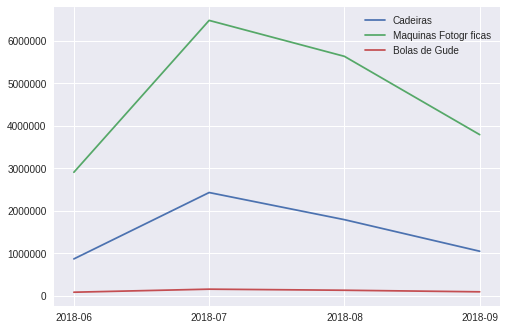

In [23]:
names = list(df['Departamento'].unique())
def name_plot(departamento, coluna):
  data = monthly.loc[departamento, coluna]
  plt.plot(data.index, data.values)

for name in names:
  name_plot(name, 'Faturamento_Total')
plt.legend(names)

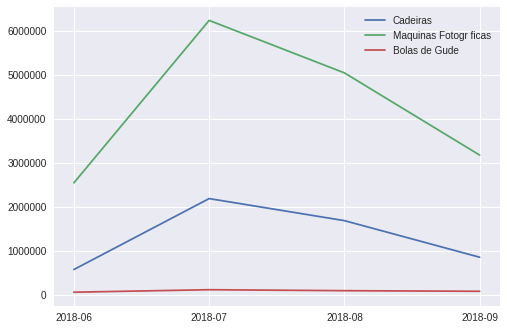

In [24]:
for name in names:
  name_plot(name, 'Custo_Total')
plt.legend(names)

In [0]:
totals = df.groupby(['Mes']).sum()
totals =  totals[['Custo_Mkt','Desconto_Produto','Desconto_Frete','Vendas']]
totals = totals.sort_index()
totals['Variação Vendas (%)'] = (totals['Vendas'].pct_change().fillna(0)*100).round(2)
totals['Variação Custo_Mkt (%)'] = (totals['Custo_Mkt'].pct_change().fillna(0)*100).round(2)
totals['Variação Desconto_Produto (%)'] = (totals['Desconto_Produto'].pct_change().fillna(0)*100).round(1)
totals['Variação Desconto_Frete (%)'] = (totals['Desconto_Frete'].pct_change().fillna(0)*100).round(1)

In [27]:
uf = df.groupby(['UF','Departamento']).sum()

Faturamento_Produto  Faturamento_Frete  \
UF Departamento                                                    
MT Bolas de Gude                      37404.0            77386.2   
   Cadeiras                          691662.0           183568.0   
   Maquinas Fotogr ficas            4696305.0            54560.0   
PE Bolas de Gude                      73503.5           131022.0   
   Cadeiras                         1231714.5           443320.0   
   Maquinas Fotogr ficas            4608900.0            84780.0   
SP Bolas de Gude                      47127.0            98006.0   
   Cadeiras                         2869897.5           721296.0   
   Maquinas Fotogr ficas            9237955.0           143950.0   

                          Custo_Produto  Custo_Frete  Custo_Mkt  \
UF Departamento                                                   
MT Bolas de Gude                  20091        66970      11732   
   Cadeiras                      488640       179480     103560   
   Maquinas Fotogr ficas        4271300       103100     185580   
PE Bolas de Gude                  22614        90456      19745   
   Cadeiras                      932280       423130     212380   
   Maquinas Fotogr ficas        3856100       229570     187830   
SP Bolas de Gude                  10145        71015      17539   
   Cadeiras                     1915800       607440     418060   
   Maquinas Fotogr ficas        7399600       371520     371520   

                          Desconto_Produto  Desconto_Frete  Vendas  Visitas  \
UF Departamento                                                               
MT Bolas de Gude                    2778.0          2977.8    6803    63594   
   Cadeiras                       130788.0         21552.0    2634    38433   
   Maquinas Fotogr ficas          261195.0        110400.0    2194    22660   
PE Bolas de Gude                    5645.5          4662.0   11321   128607   
   Cadeiras                       247925.5         54480.0    4976   104555   
   Maquinas Fotogr ficas          265000.0        165660.0    2061    29792   
SP Bolas de Gude                    3598.0          3444.0   10505   104903   
   Cadeiras                       551802.5         88624.0   10081   172756   
   Maquinas Fotogr ficas          484445.0        268850.0    4068    53791   

                          Faturamento_Total  Custo_Total  Desconto_Total  \
UF Departamento                                                            
MT Bolas de Gude                   114790.2        98793          5755.8   
   Cadeiras                        875230.0       771680        152340.0   
   Maquinas Fotogr ficas          4750865.0      4559980        371595.0   
PE Bolas de Gude                   204525.5       132815         10307.5   
   Cadeiras                       1675034.5      1567790        302405.5   
   Maquinas Fotogr ficas          4693680.0      4273500        430660.0   
SP Bolas de Gude                   145133.0        98699          7042.0   
   Cadeiras                       3591193.5      2941300        640426.5   
   Maquinas Fotogr ficas          9381905.0      8142640        753295.0   

                             Lucro  
UF Departamento                     
MT Bolas de Gude           10241.4  
   Cadeiras               -48790.0  
   Maquinas Fotogr ficas -180710.0  
PE Bolas de Gude           61403.0  
   Cadeiras              -195161.0  
   Maquinas Fotogr ficas  -10480.0  
SP Bolas de Gude           39392.0  
   Cadeiras                 9467.0  
   Maquinas Fotogr ficas  485970.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


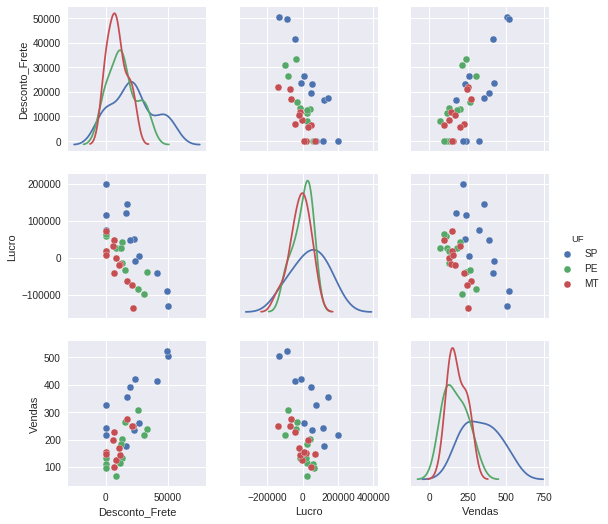

In [59]:
import seaborn as sns
aux = df
aux = aux[['Desconto_Frete', 'Lucro', 'Vendas', 'UF', 'Item', 'Departamento']]
aux['UF-Item'] = aux[['UF', 'Item']].apply(lambda x: '-'.join(x), axis=1)

maq = aux.query('Departamento != ["Bolas de Gude", "Cadeiras"]')
maq = maq.drop(columns = ['UF-Item', 'Item', 'Departamento'])
sns.pairplot(maq, hue = 'UF', diag_kind = 'kde')

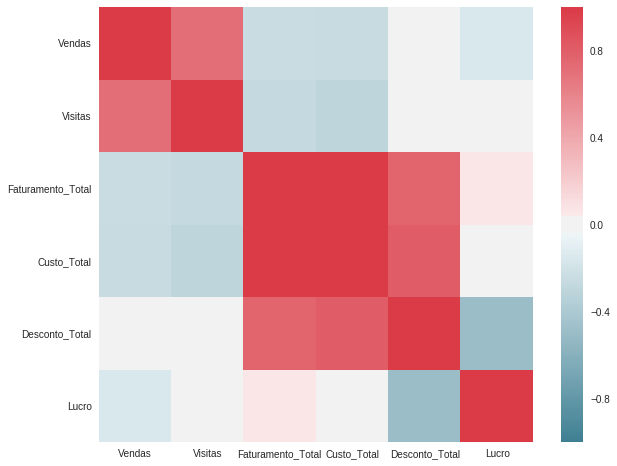

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

f, ax = plt.subplots(figsize=(10, 8))
corr = aux.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Base Externa

In [0]:
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/Vendas/ibge.csv', sep=",")
df.Year = pd.to_datetime(df.Year.astype(str)+df.Month.astype(str),format='%Y%m')
df.set_index(df.Year, inplace=True)
df.sort_values(by=['Year'], inplace=True)
df.drop(['Year','Month'], axis=1, inplace=True)
df.index
ts = df['Volume'] 

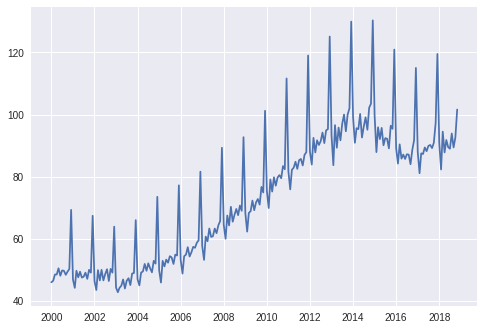

In [115]:
ts.dropna(inplace=True)
plt.plot(ts)

In [0]:
def evaluateArima(dataset, p_values, d_values, q_values):
  """ Verifica qual a combinacao de parametros p, d, q do ARIMA que minimizam o AIC
  
  Args:
      dataset (Series): serie temporal
      p_values (int): range da permutacao do parametro p
      d_values (int): range da permutacao do parametro d
      q_values (int): range da permutacao do parametro q
  
  Returns:
      mod.fit() do Arima dos parametros p, d, q que resultaram no menor AIC
  
  """
  p = range(0, p_values)
  d = range(0, d_values)
  q = range(0, q_values)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  best_aic, best_result, best_param, best_param_seasonal = float("inf"), float("inf"), None, None
  for param in pdq:
    for param_seasonal in seasonal_pdq:
      try:
        mod = sm.tsa.statespace.SARIMAX(dataset,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
        if results.aic < best_aic:
           best_aic, best_result, best_param, best_param_seasonal = results.aic, results, param, param_seasonal
        #print('AIC:{} - ARIMA{}x{}12'.format(results.aic, param, param_seasonal))
      except:
            continue
  print('Menor AIC: %.3f - ARIMA%sx%s' % (best_aic, best_param, best_param_seasonal))
  #print('Menor AIC:{} - ARIMA{}x{}12'.format(best_aic, best_param, best_param_seasonal))
  return best_result
  

### Resultados do ARIMA

In [120]:
results = evaluateArima(ts, 2, 2, 2)

Menor AIC: 822.466 - ARIMA(1, 1, 1)x(0, 1, 1, 12)


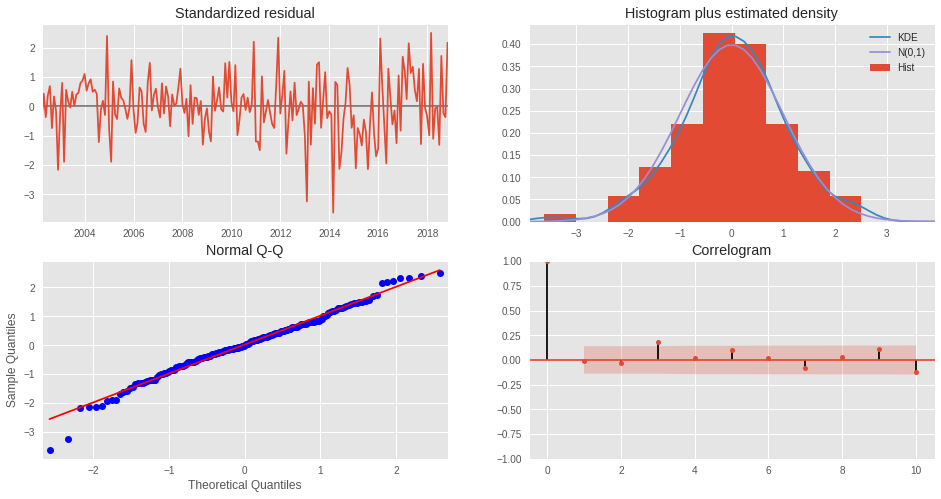

In [121]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Previsao em dados existentes

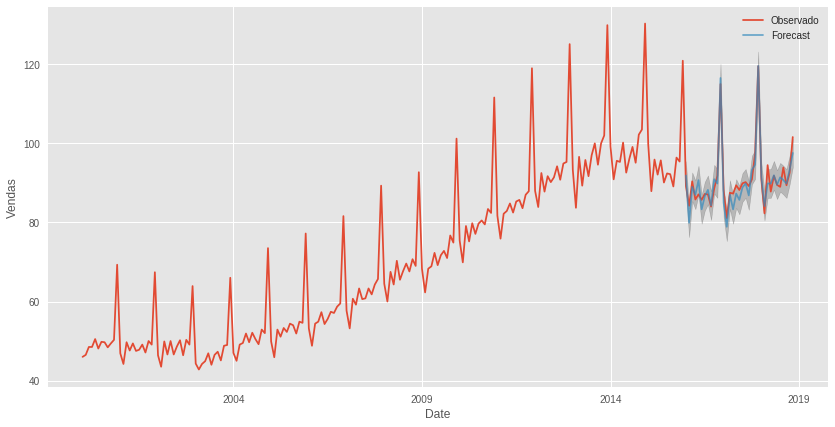

In [122]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int() # limites superior e inferior dos erros

ax = ts['1992':].plot(label='Observado')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Vendas')
plt.legend()

plt.show()

### Calcula erro sobre a previsao

In [123]:
ts_forecasted = pred.predicted_mean
ts_truth = ts['2014-01-01':]

# Erro quadratico medio
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('Erro quadratico medio da previsao {}'.format(round(mse, 2)))

# Raiz do erro quadratico medio
rmse = np.sqrt(mse)
print('Raiz do erro quadratico medio da previsao {}'.format(round(rmse, 2)))

Erro quadratico medio da previsao 5.26
Raiz do erro quadratico medio da previsao 2.29


### Elabora o Forecast

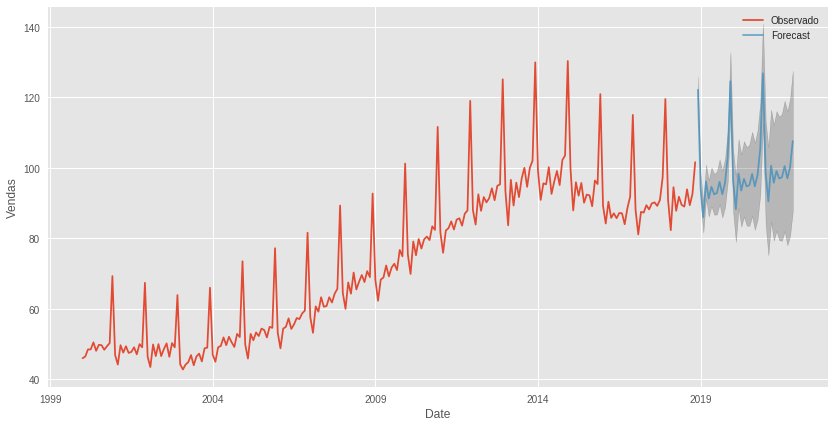

In [124]:
# get_prediction vs get_forecast: trazem o mesmo output, o que muda sao os parametros da funcao
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()

ax = ts.plot(label='Observado')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Vendas')

plt.legend()
plt.show()

### Saída com valores previstos, limiares inferior e superior

In [127]:
pred_uc.predicted_mean
predicted = pd.DataFrame({'date':pred_uc.predicted_mean.index, 'previsto':pred_uc.predicted_mean.values})
predicted.set_index('date', inplace=True)

pred_uc_ci = pred_uc.conf_int(alpha=0.05) #  dataFrame de intervalos com 95% de confiança
previsto = pd.concat([predicted,pred_uc_ci], axis=1)

previsto.tail(10)

,previsto,lower Volume,upper Volume
date,,,
2021-02-01,90.480843,75.189378,105.772308
2021-03-01,100.605012,84.737255,116.472768
2021-04-01,95.768553,79.340029,112.197077
2021-05-01,99.102256,82.132560,116.071952
2021-06-01,96.961812,79.467429,114.456195
2021-07-01,97.313166,79.309438,115.316894
2021-08-01,100.511511,82.012444,119.010579
2021-09-01,96.997978,78.016496,115.979460
2021-10-01,100.156528,80.704591,119.608465
